In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Import data, vectorization, and train/test split

In [2]:
df = pd.read_csv('data/presidential_speeches_cleaned.csv', encoding='utf-8', usecols=['Party', 'Cleaned'])
df.sample(5)

,Party,Cleaned
739,Democratic,good evening last week warring factions bosnia...
812,Democratic,thank everybody thank thank much thank everybo...
873,Democratic,president good afternoon earlier today briefed...
617,Democratic,good evening pauline frederick npr national pu...
725,Democratic,distinguished guests services general powell j...


In [3]:
enc = LabelEncoder()
enc.fit(df['Party'])
encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the confusion matrices
df['Party'] = enc.transform(df['Party'])
encoded_labels

{'Democratic': 0, 'Republican': 1}

In [4]:
X = df.drop('Party',axis=1)
y = df['Party']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=97, stratify=y)

In [5]:
vect = TfidfVectorizer()

preprocess = make_column_transformer(
    (vect, 'Cleaned'),
    remainder='drop'
)

## Models

### SGD

In [6]:
sgd_clf = SGDClassifier(class_weight='balanced')

sgd_pipe = make_pipeline(preprocess, sgd_clf)

In [7]:
sgd_param_grid = {
    'sgdclassifier__loss': ['hinge', 'log'],
    'sgdclassifier__alpha': [ 0.001, 0.01, 0.1],
    'sgdclassifier__penalty': ['l2', 'l1'],
}

In [8]:
sgd_gs = GridSearchCV(sgd_pipe, sgd_param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=10, refit=True)
sgd_gs.fit(X_train, y_train)

print(sgd_gs.best_score_, sgd_gs.best_estimator_, sep='\n')

Fitting 10 folds for each of 12 candidates, totalling 120 fits
0.8399240293827152
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'Cleaned')])),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.001, class_weight='balanced'))])


In [9]:
y_pred_sgd = sgd_gs.predict(X_test)

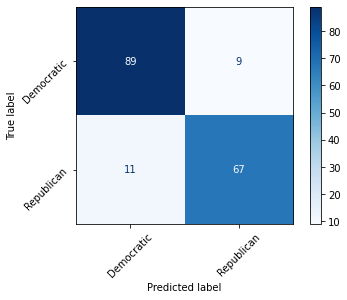

In [10]:
cm = confusion_matrix(y_test, y_pred_sgd, labels=sgd_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.display_labels = encoded_labels
disp.plot(cmap=plt.cm.Blues)
disp.ax_.tick_params(axis='both', rotation=45)

### SVM

In [11]:
svm = SVC(kernel='linear')

svm_pipe = make_pipeline(preprocess, svm)

In [12]:
svm_param_grid = {
    'svc__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

In [13]:
svm_gs = GridSearchCV(svm_pipe, svm_param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=10, refit=True)
svm_gs.fit(X_train, y_train)

print(svm_gs.best_score_, svm_gs.best_estimator_, sep='\n')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0.8139695805275402
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'Cleaned')])),
                ('svc', SVC(kernel='linear'))])


In [14]:
y_pred_svm = svm_gs.predict(X_test)

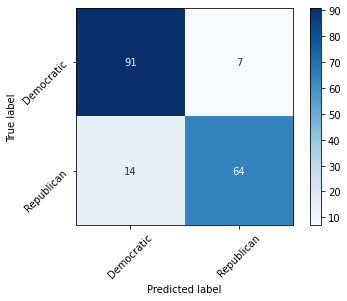

In [15]:
cm = confusion_matrix(y_test, y_pred_svm, labels=svm_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.display_labels = encoded_labels
disp.plot(cmap=plt.cm.Blues)
disp.ax_.tick_params(axis='both', rotation=45);

### RF

In [16]:
rf = RandomForestClassifier()

rf_pipe = make_pipeline(preprocess, rf)

In [17]:
rf_param_grid = {
    'randomforestclassifier__n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
}

In [18]:
rf_gs = GridSearchCV(rf_pipe, rf_param_grid, cv=10, scoring='f1_macro', n_jobs=-1, verbose=10, refit=True)
rf_gs.fit(X_train, y_train)
print(rf_gs.best_score_, rf_gs.best_estimator_, sep='\n')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0.6942274762700903
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('tfidfvectorizer',
                                                  TfidfVectorizer(),
                                                  'Cleaned')])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=80))])


In [19]:
y_pred_rf = rf_gs.predict(X_test)

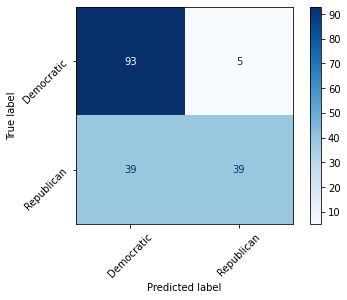

In [20]:
cm = confusion_matrix(y_test, y_pred_rf, labels=rf_gs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.display_labels = encoded_labels
disp.plot(cmap=plt.cm.Blues)
disp.ax_.tick_params(axis='both', rotation=45);